# What are `TargetPixelFile` objects?

Target Pixel Files (TPFs) are a file common to Kepler/K2 and the TESS mission. They contain movies of the pixel data centered on a single target star.

TPFs can be thought of as stacks of images, with one image for every timestamp the telescope took data. Each timestamp is referred to as a **cadence**. These images are cut out 'postage stamps' of the full observation to make them easier to work with. 

TPFs are given in FITS files, which you can read more about [here](https://fits.gsfc.nasa.gov/fits_primer.html). *Lightkurve* includes tools for you to work directly with these files easily and intuitively.

In this tutorial we'll cover the basics of working with TPFs. In *lightkurve* there are classes to work with each mission. For example `KeplerTargetPixelFile` deals with data from the Kepler (and K2) mission. `TessTargetPixelFile` deals with data from the TESS mission. We'll use a Kepler TPF as an example.

To load a `KeplerTargetPixelFile` from a local path or remote url, simply call Lightkurve's [read](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.read.html?highlight=read#lightkurve.LightCurve.read) function using the location of the file as the parameter:

In [1]:
import lightkurve as lk
tpf = lk.read("https://archive.stsci.edu/pub/kepler/target_pixel_files/0069/006922244/kplr006922244-2010078095331_lpd-targ.fits.gz")

You can also search for the url automatically using the [search_targetpixelfile()](https://docs.lightkurve.org/reference/api/lightkurve.search_targetpixelfile.html?highlight=search_targetpixelfile) function. This will search for the right file in the [MAST data archive](https://archive.stsci.edu/kepler/) which holds all of the Kepler and K2 data.
In this case we want the Target Pixel File with Kepler ID 6922244 for Quarter 4 (Kepler's observations were split into quarters of a year):

In [2]:
from lightkurve import search_targetpixelfile
tpf = search_targetpixelfile('KIC 6922244', author="Kepler", quarter=4, cadence="long").download()

You can also pass the name of the target or its astronomical coordinates as a parameter to `search_targetpixelfile()`.

The above code has created a variable named `tpf` which is a Python object of type `KeplerTargetPixelFile`:

In [3]:
tpf

KeplerTargetPixelFile Object (ID: 6922244)

We can access lots of meta data using this object in a simple way. For example, we can find the mission name, and the quarter that the data was taken in by typing the following:

In [4]:
tpf.meta['MISSION']

'Kepler'

In [5]:
tpf.meta['QUARTER']

4

You can find the full list of properties in the [API documentation](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.KeplerTargetPixelFile.html#lightkurve.targetpixelfile.KeplerTargetPixelFile) on this object.

The most interesting data in a `KeplerTargetPixelFile` object are the `flux` and `time` values which give access to the brightness of the observed target over time. You can access the timestamps of the observations using the `time` property:

In [6]:
tpf.time

<Time object: scale='tdb' format='bkjd' value=[352.37632485 352.39675805 352.43762445 ... 442.16263546 442.18306983
 442.2035041 ]>

By default, `time` is in the Kepler-specific *Barycentric Kepler Julian Day* format (BKJD).

Because this is an AstroPy Time object, you access to human-readable ISO timestamps using the `time.iso` property:

In [7]:
tpf.time.iso

array(['2009-12-19 21:01:54.467', '2009-12-19 21:31:19.895',
       '2009-12-19 22:30:10.752', ..., '2010-03-19 15:54:11.704',
       '2010-03-19 16:23:37.233', '2010-03-19 16:53:02.754'], dtype='<U23')

**Beware:** these timestamps are in the Solar System Barycentric frame (TDB) and do not include corrections for light travel time or leap seconds.  To use a different time scale, such as the Earth-centered UTC system, you can use [AstroPy's time scale conversion features](http://docs.astropy.org/en/stable/time/#time-scale).  For example: 

In [8]:
tpf.time.utc.iso

array(['2009-12-19 21:00:48.284', '2009-12-19 21:30:13.712',
       '2009-12-19 22:29:04.569', ..., '2010-03-19 15:53:05.518',
       '2010-03-19 16:22:31.048', '2010-03-19 16:51:56.568'], dtype='<U23')

Next, let's look at the actual image data, which is available via the `flux` property:

In [9]:
tpf.flux.shape

(4116, 5, 5)

The `flux` data is a 4116x5x5 array in units electrons/second. The first axis is the time axis, and the images themselves are 5 pixels by 5 pixels. You can use the `plot` method on the `KeplerTargetPixelFile` object to view the data. (By default, this will show just one cadence of the data. But you can pass the cadence you want to look at to the `frame` keyword if you would like to check a particular flux point for thruster firings, cosmic rays or asteroids.)

<AxesSubplot:title={'center':'Target ID: 6922244, Cadence: 11914'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

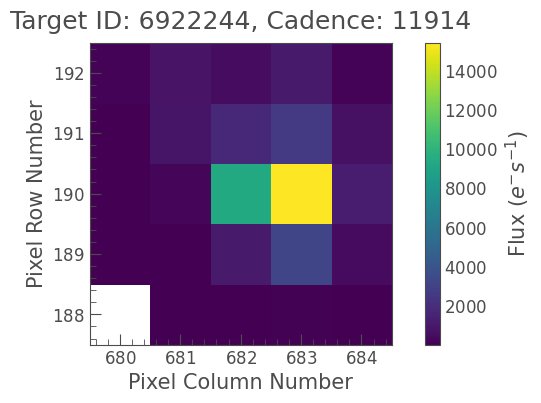

In [10]:
%matplotlib inline
tpf.plot(frame=0);

The values shown in this image are also directly accessible as an array:

In [11]:
tpf.flux[0]

<Quantity [[          nan, 5.6079335e+00, 5.1491142e+01, 8.4241745e+01,
            3.0221334e+01],
           [4.4045620e+01, 7.6861229e+01, 1.1227759e+03, 3.2262029e+03,
            4.5486777e+02],
           [2.5911165e+01, 2.2907593e+02, 9.3626543e+03, 2.3606273e+04,
            1.2087750e+03],
           [4.0100830e+01, 8.8543927e+02, 1.7102118e+03, 2.6254871e+03,
            7.0796606e+02],
           [1.5719417e+02, 8.3713440e+02, 5.1021539e+02, 1.1501041e+03,
            1.8313370e+02]] electron / s>

You can use normal `numpy` methods on these to find the shape, mean etc!

We can now turn this Target Pixel File into a light curve, with a single flux value for every time value. Each of the pixels are 4 arcseconds across. The point spread function (PSF) of the telescope causes the light from the star fall onto several different pixels, which can be seen in the image above. Because of this spreading, we have to sum up many pixels to collect all the light from the source. To do this we sum up all the pixels in an **aperture**. An aperture is a pixel mask, where we take only the pixels related to the target. 

The *Kepler* pipeline adds an aperture mask to each target pixel file. This aperture determines which pixels are summed to create a 1-D light curve of the target. There are some science cases where you might want to create a different aperture. For example, there may be a nearby contaminant or you may want to measure the background. 

The standard pipeline aperture is easily accessed in a `KeplerTargetPixelFile` object using [tpf.pipeline_mask](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.pipeline_mask.html?highlight=pipeline_mask), which is a boolean array:

In [12]:
tpf.pipeline_mask

array([[False, False, False, False, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False,  True,  True,  True, False],
       [False, False, False,  True, False]])

We can also plot this aperture over the target pixel file above to see if the flux of the star is all contained within the aperture.

<AxesSubplot:title={'center':'Target ID: 6922244, Cadence: 11914'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

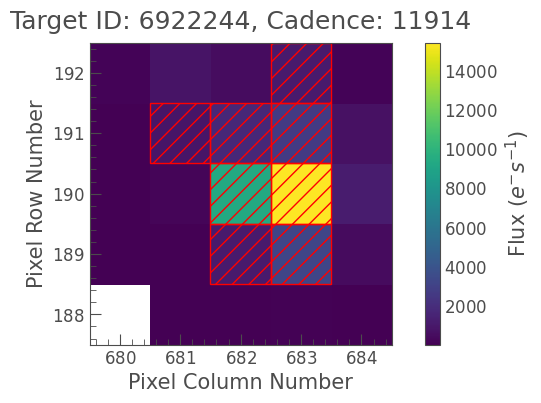

In [13]:
tpf.plot(aperture_mask=tpf.pipeline_mask);

Now that we have the aperture we can create a Simple Aperture Photometry light curve in the next tutorial.

Finally, note that you can inspect all the raw metadata of the target by taking a look at the 'header' of the FITS file, which contains information about the data set. Let's just print the first 10 lines:

In [14]:
tpf.get_header()[:10]

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-23'         / file creation date.                            
CREATOR = '917482 TargetPixelExporterPipelineModule' / pipeline job and program 

We can look at the values in the second extension of the fits file by accessing the AstroPy FITS `HDUList` object. For example, to look at all the column titles:

In [15]:
tpf.hdu[1].header['TTYPE*']

TTYPE1  = 'TIME    '           / column title: data time stamps                 
TTYPE2  = 'TIMECORR'           / column title: barycenter - timeslice correction
TTYPE3  = 'CADENCENO'          / column title: unique cadence number            
TTYPE4  = 'RAW_CNTS'           / column title: raw pixel counts                 
TTYPE5  = 'FLUX    '           / column title: calibrated pixel flux            
TTYPE6  = 'FLUX_ERR'           / column title: 1-sigma calibrated uncertainty   
TTYPE7  = 'FLUX_BKG'           / column title: calibrated background flux       
TTYPE8  = 'FLUX_BKG_ERR'       / column title: 1-sigma cal. background uncertain
TTYPE9  = 'COSMIC_RAYS'        / column title: cosmic ray detections            
TTYPE10 = 'QUALITY '           / column title: pixel quality flags              
TTYPE11 = 'POS_CORR1'          / column title: column position correction       
TTYPE12 = 'POS_CORR2'          / column title: row position correction          
TTYPE13 = 'RB_LEVEL'        